# RANDOM FOREST

Objetivo: Establecer un segundo modelo baseline usando Random Forest para comparar con Regresión Logística y los modelos de Gradient Boosting.

- Es un modelo ensemble robusto y ampliamente usado
- No requiere escalado de variables
- Maneja bien variables categóricas codificadas
- Proporciona importancia de features nativa
- Sirve como punto intermedio entre RL (lineal) y Gradient Boosting (más complejo)

Fases temporales:
- T0 (Matrícula)        : Variables disponibles al momento de inscripción
- T1 (Fin 1er Semestre) : T0 + variables académicas del 1er semestre, información de matrícula y deudor
- T2 (Fin 2do Semestre) : T1 + variables académicas del 2do semestre

Preprocesamiento para Random Forest:
- NO requiere escalado
- Label Encoding para categóricas
- Target Encoding para 'course' (alta cardinalidad)
- class_weight='balanced' para desbalance

## 0. Librerias y configuración

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder

# Modelo
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

# Target Encoding
from category_encoders import TargetEncoder

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Seed para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Directorio de salida
OUTPUT_DIR = "../outputs/figures/modelado/baseline_RF/"
OUTPUT_DIR_REPORTES = "../outputs/models/baseline_RF/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR_REPORTES, exist_ok=True)

# mlflow
import mlflow
import mlflow.sklearn

## 1. Carga de datos preprocesados

In [4]:
# Cargar dataset preprocesado
df = pd.read_csv('../data/processed/preprocessed_data.csv')

print(f"Dataset cargado: {df.shape[0]} filas x {df.shape[1]} columnas")
print(df['target_binario'].value_counts())
print(f"\nRatio de desbalance: {df['target_binario'].value_counts()[0] / df['target_binario'].value_counts()[1]:.2f}:1")

df.head()

Dataset cargado: 4424 filas x 36 columnas
target_binario
0    3003
1    1421
Name: count, dtype: int64

Ratio de desbalance: 2.11:1


,application_order,course,daytimeevening_attendance,previous_qualification_grade,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,international,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_evaluations,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,is_single,application_mode_risk,previous_qualification_risk,mothers_qualification_level,fathers_qualification_level,mothers_occupation_level,fathers_occupation_level,target_binario
0,5,171,1,122.0000,127.3000,1,0,0,1,1,0,20,0,0,0,0,0,0.0000,0,0,0,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Secundaria,Otro_Trabajo,Otro_Trabajo,1
1,1,9254,1,160.0000,142.5000,1,0,0,0,1,0,19,0,0,6,6,6,14.0000,0,0,6,6,6,13.6667,0,13.9000,-0.3000,0.7900,1,Bajo_Riesgo,Bajo_Riesgo,Secundaria,Superior,Profesional,Profesional,0
2,5,9070,1,122.0000,124.8000,1,0,0,0,1,0,19,0,0,6,0,0,0.0000,0,0,6,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Baja,Otro_Trabajo,Otro_Trabajo,1
3,2,9773,1,122.0000,119.6000,1,0,0,1,0,0,20,0,0,6,8,6,13.4286,0,0,6,10,5,12.4000,0,9.4000,-0.8000,-3.1200,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Basica_Baja,Otro_Trabajo,Profesional,0
4,1,8014,0,100.0000,141.5000,0,0,0,1,0,0,45,0,0,6,9,5,12.3333,0,0,6,6,6,13.0000,0,13.9000,-0.3000,0.7900,0,Alto_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Media,Otro_Trabajo,Otro_Trabajo,0


## 2. Definición de variables por fase temporal (T0, T1, T2)

In [5]:
# =============================================================================
# DEFINICIÓN DE VARIABLES POR TIPO
# =============================================================================

# TARGET
TARGET = 'target_binario'

# -----------------------------------------------------------------------------
# VARIABLES BINARIAS (no requieren encoding, ya son 0/1)
# -----------------------------------------------------------------------------
VARS_BINARIAS_T0 = [
    'daytimeevening_attendance',
    'displaced',
    'educational_special_needs',
    'gender',
    'scholarship_holder',
    'international',
    'is_single'
]

VARS_BINARIAS_T1 = [
    'debtor',
    'tuition_fees_up_to_date'
]

# -----------------------------------------------------------------------------
# VARIABLES NUMÉRICAS (NO requieren escalado para RF)
# -----------------------------------------------------------------------------
VARS_NUMERICAS_T0 = [
    'age_at_enrollment',
    'admission_grade',
    'previous_qualification_grade'
]

VARS_NUMERICAS_T1 = [
    'curricular_units_1st_sem_credited',
    'curricular_units_1st_sem_enrolled',
    'curricular_units_1st_sem_evaluations',
    'curricular_units_1st_sem_approved',
    'curricular_units_1st_sem_grade',
    'curricular_units_1st_sem_without_evaluations',
    'unemployment_rate',
    'inflation_rate',
    'gdp'
]

VARS_NUMERICAS_T2 = [
    'curricular_units_2nd_sem_credited',
    'curricular_units_2nd_sem_enrolled',
    'curricular_units_2nd_sem_evaluations',
    'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_grade',
    'curricular_units_2nd_sem_without_evaluations'
]

# -----------------------------------------------------------------------------
# VARIABLES CATEGÓRICAS AGRUPADAS (requieren Label Encoding)
# -----------------------------------------------------------------------------
VARS_CATEGORICAS_AGRUPADAS_T0 = [
    'application_mode_risk',
    'previous_qualification_risk',
    'mothers_qualification_level',
    'fathers_qualification_level',
    'mothers_occupation_level',
    'fathers_occupation_level'
]

# -----------------------------------------------------------------------------
# VARIABLES CATEGÓRICAS PARA TARGET ENCODING
# -----------------------------------------------------------------------------
VARS_TARGET_ENCODING_T0 = ['course']

# -----------------------------------------------------------------------------
# VARIABLE ORDINAL (se trata como numérica)
# -----------------------------------------------------------------------------
VARS_ORDINALES_T0 = ['application_order']

# =============================================================================
# COMPOSICIÓN DE VARIABLES POR FASE TEMPORAL
# =============================================================================

# T0: Variables disponibles al momento de matrícula
VARS_T0 = (
    VARS_BINARIAS_T0 +
    VARS_NUMERICAS_T0 +
    VARS_CATEGORICAS_AGRUPADAS_T0 +
    VARS_TARGET_ENCODING_T0 +
    VARS_ORDINALES_T0
)

# T1: T0 + variables del 1er semestre
VARS_T1 = (
    VARS_T0 +
    VARS_BINARIAS_T1 +
    VARS_NUMERICAS_T1
)

# T2: T1 + variables del 2do semestre
VARS_T2 = (
    VARS_T1 +
    VARS_NUMERICAS_T2
)

print("================================================================================")
print("  VARIABLES POR FASE TEMPORAL")
print("================================================================================")
print(f"\n T0 (Matrícula): {len(VARS_T0)} variables")
print(f" T1 (Fin 1er Sem): {len(VARS_T1)} variables (+{len(VARS_T1) - len(VARS_T0)})")
print(f" T2 (Fin 2do Sem): {len(VARS_T2)} variables (+{len(VARS_T2) - len(VARS_T1)})")

  VARIABLES POR FASE TEMPORAL

 T0 (Matrícula): 18 variables
 T1 (Fin 1er Sem): 29 variables (+11)
 T2 (Fin 2do Sem): 35 variables (+6)


## 3. Split TRAIN/TEST 

In [6]:
# =============================================================================
# SPLIT ESTRATIFICADO 80/20
# =============================================================================

X = df[VARS_T2].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("================================================================================")
print("  SPLIT TRAIN/TEST")
print("================================================================================")
print(f"\nTrain: {X_train.shape[0]} ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]} ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\nDistribución del target en Train:")
print(y_train.value_counts())
print(f"Ratio de desbalance:: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

print(f"\nDistribución del target en Test:")
print(y_test.value_counts())
print(f"Ratio de desbalance:: {y_test.value_counts()[0] / y_test.value_counts()[1]:.2f}:1")

  SPLIT TRAIN/TEST

Train: 3539 (80.0%)
Test:  885 (20.0%)

Distribución del target en Train:
target_binario
0    2402
1    1137
Name: count, dtype: int64
Ratio de desbalance:: 2.11:1

Distribución del target en Test:
target_binario
0    601
1    284
Name: count, dtype: int64
Ratio de desbalance:: 2.12:1


## 4. Funciones de preprocesamiento para RANDOM FOREST

In [7]:
def obtiene_variables_por_fase(fase):
    """
    Retorna las listas de variables según la fase temporal.
    """
    if fase == 'T0':
        return {
            'binarias': VARS_BINARIAS_T0,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0,
            'categoricas_le': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T0
        }
    elif fase == 'T1':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1,
            'categoricas_le': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T1
        }
    elif fase == 'T2':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1 + VARS_NUMERICAS_T2,
            'categoricas_le': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T2
        }
    else:
        raise ValueError(f"Fase no válida: {fase}. Usar 'T0', 'T1', o 'T2'")


def preprocesamiento_RF(X_train, X_test, y_train, fase):
    # Preprocesa los datos para Random Forest    
    
    variables_fase = obtiene_variables_por_fase(fase)
    
    # Seleccionar solo las variables de la fase
    X_train_fase = X_train[variables_fase['all']].copy()
    X_test_fase = X_test[variables_fase['all']].copy()
    
    # Diccionario para guardar encoders
    label_encoders = {}
    
    # -------------------------------------------------------------------------
    # 1. TARGET ENCODING para 'course' 
    # -------------------------------------------------------------------------
    te = TargetEncoder(cols=variables_fase['categoricas_te'], smoothing=0.3)
    
    for col in variables_fase['categoricas_te']:
        X_train_fase[col + '_encoded'] = te.fit_transform(X_train_fase[[col]], y_train)[col]
        X_test_fase[col + '_encoded'] = te.transform(X_test_fase[[col]])[col]
        # Eliminar columna original
        X_train_fase = X_train_fase.drop(columns=[col])
        X_test_fase = X_test_fase.drop(columns=[col])
    
    # -------------------------------------------------------------------------
    # 2. LABEL ENCODING para categóricas agrupadas
    # -------------------------------------------------------------------------
    for col in variables_fase['categoricas_le']:
        le = LabelEncoder()
        X_train_fase[col] = le.fit_transform(X_train_fase[col].astype(str))
        X_test_fase[col] = le.transform(X_test_fase[col].astype(str))
        label_encoders[col] = le
    
    # -------------------------------------------------------------------------
    # Guardar información
    # -------------------------------------------------------------------------
    feature_names = X_train_fase.columns.tolist()
    preprocessors = {
        'target_encoder': te,
        'label_encoders': label_encoders,
        'feature_names': feature_names
    }
    
    return X_train_fase, X_test_fase, feature_names, preprocessors


## 5. Funciones entrenamiento

In [8]:
# Entrenamiento con parámetros por defecto
def entrena_RF(X_train, y_train, fase, cv_folds=5):
    """Entrena y evalúa Random Forest con Cross-Validation."""

    mlflow.end_run()
      
    print("================================================================================")
    print(f"  ENTRENAMIENTO Random Forest - FASE {fase}")
    print("================================================================================")
    print(f"\nVariables: {X_train.shape[1]}")
    print(f"Registros: {X_train.shape[0]}")
    
    print(f"\nHiperparámetros (por defecto):")
    print(f"   • n_estimators: 100")
    print(f"   • max_depth: None (sin límite)")
    print(f"   • min_samples_split: 2")
    print(f"   • min_samples_leaf: 1")
    print(f"   • max_features: sqrt")
    print(f"   • class_weight: balanced")
    
    # -------------------------------------------------------------------------
    # Cross-Validation con loop manual
    # -------------------------------------------------------------------------
    print(f"\nCross-Validation ({cv_folds}-fold):")
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    # Almacenar resultados por fold
    cv_results = {
        'train_accuracy': [], 'test_accuracy': [],
        'train_precision': [], 'test_precision': [],
        'train_recall': [], 'test_recall': [],
        'train_f1': [], 'test_f1': [],
        'train_roc_auc': [], 'test_roc_auc': []
    }
    
    oob_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Crear y entrenar modelo
        model_RF = RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            bootstrap=True,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=-1,
            oob_score=True
        )
        model_RF.fit(X_fold_train, y_fold_train)
        
        # Guardar OOB score del fold
        oob_scores.append(model_RF.oob_score_)
        
        # Predicciones
        y_train_pred = model_RF.predict(X_fold_train)
        y_train_proba = model_RF.predict_proba(X_fold_train)[:, 1]
        y_val_pred = model_RF.predict(X_fold_val)
        y_val_proba = model_RF.predict_proba(X_fold_val)[:, 1]
        
        # Métricas Train
        cv_results['train_accuracy'].append(accuracy_score(y_fold_train, y_train_pred))
        cv_results['train_precision'].append(precision_score(y_fold_train, y_train_pred))
        cv_results['train_recall'].append(recall_score(y_fold_train, y_train_pred))
        cv_results['train_f1'].append(f1_score(y_fold_train, y_train_pred))
        cv_results['train_roc_auc'].append(roc_auc_score(y_fold_train, y_train_proba))
        
        # Métricas Validation
        cv_results['test_accuracy'].append(accuracy_score(y_fold_val, y_val_pred))
        cv_results['test_precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_results['test_recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_results['test_f1'].append(f1_score(y_fold_val, y_val_pred))
        cv_results['test_roc_auc'].append(roc_auc_score(y_fold_val, y_val_proba))
    
    # Convertir a numpy arrays
    for key in cv_results:
        cv_results[key] = np.array(cv_results[key])
    
    # -------------------------------------------------------------------------
    # Resultados por fold
    # -------------------------------------------------------------------------
    print("\n Resultados por fold:")
    for i in range(cv_folds):
        print(f"\n  Fold {i+1}:")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            train_score = cv_results[f'train_{metric}'][i]
            val_score = cv_results[f'test_{metric}'][i]
            print(f"    {metric:<10} | Train: {train_score:.4f} | Val: {val_score:.4f}")

    
    # -------------------------------------------------------------------------
    # Resultados por fold
    # -------------------------------------------------------------------------
    print("\n Resultados por fold:")
    for i in range(cv_folds):
        print(f"\n  Fold {i+1}:")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            train_score = cv_results[f'train_{metric}'][i]
            val_score = cv_results[f'test_{metric}'][i]
            print(f"    {metric:<10} | Train: {train_score:.4f} | Val: {val_score:.4f}")

    # =========================================================================
    # CURVA DE APRENDIZAJE: F1-Score vs n_estimators
    # =========================================================================
    print(f"\nGenera curva de aprendizaje (F1 vs n_estimators)...")
    
    # Rango de n_estimators a evaluar
    n_estimators_range = [10, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500]
    
    cv_curve = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    all_train_f1 = []
    all_val_f1 = []
    
    for fold, (train_idx, val_idx) in enumerate(cv_curve.split(X_train, y_train)):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        train_f1_fold = []
        val_f1_fold = []
        
        # Usar warm_start para eficiencia
        modelo_rf = RandomForestClassifier(
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            bootstrap=True,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=-1,
            warm_start=True,
            n_estimators=0
        )
        
        for n_est in n_estimators_range:
            modelo_rf.n_estimators = n_est
            modelo_rf.fit(X_fold_train, y_fold_train)
            
            y_train_pred = modelo_rf.predict(X_fold_train)
            y_val_pred = modelo_rf.predict(X_fold_val)
            
            train_f1_fold.append(f1_score(y_fold_train, y_train_pred))
            val_f1_fold.append(f1_score(y_fold_val, y_val_pred))
        
        all_train_f1.append(train_f1_fold)
        all_val_f1.append(val_f1_fold)
    
    # Calcular media y std
    train_f1_mean = np.array(all_train_f1).mean(axis=0)
    train_f1_std = np.array(all_train_f1).std(axis=0)
    val_f1_mean = np.array(all_val_f1).mean(axis=0)
    val_f1_std = np.array(all_val_f1).std(axis=0)
    
    # =========================================================================
    # GRAFICAR CURVA DE APRENDIZAJE
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Train
    ax.plot(n_estimators_range, train_f1_mean, label='Train F1', color='#3498DB', linewidth=2, marker='o')
    ax.fill_between(n_estimators_range, 
                    train_f1_mean - train_f1_std, 
                    train_f1_mean + train_f1_std, 
                    color='#3498DB', alpha=0.2)
    
    # Validation
    ax.plot(n_estimators_range, val_f1_mean, label='Validation F1', color='#E74C3C', linewidth=2, marker='s')
    ax.fill_between(n_estimators_range, 
                    val_f1_mean - val_f1_std, 
                    val_f1_mean + val_f1_std, 
                    color='#E74C3C', alpha=0.2)
    
    ax.set_xlabel('Número de Árboles (n_estimators)', fontsize=12)
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_title(f'Curva de Aprendizaje - Random Forest {fase}\n(Media ± Std de {cv_folds}-Fold CV) - Sin Optimizar', fontsize=14)
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Marcar n_estimators por defecto (100)
    ax.axvline(x=100, color='green', linestyle='--', alpha=0.7, linewidth=2)
    idx_default = n_estimators_range.index(100)
    ax.scatter([100], [val_f1_mean[idx_default]], color='green', s=150, zorder=5, 
               label=f'n_estimators default: 100')
    
    # Marcar mejor n_estimators
    best_idx = np.argmax(val_f1_mean)
    best_n_est = n_estimators_range[best_idx]
    if best_n_est != 100:
        ax.axvline(x=best_n_est, color='orange', linestyle=':', alpha=0.7, linewidth=2)
        ax.scatter([best_n_est], [val_f1_mean[best_idx]], color='orange', s=150, zorder=5,
                   label=f'Mejor n_estimators: {best_n_est}')
    
    ax.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}curva_aprendizaje_rf_{fase}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calcular gap
    gap_default = train_f1_mean[idx_default] - val_f1_mean[idx_default]
    gap_best = train_f1_mean[best_idx] - val_f1_mean[best_idx]
    
    print(f"\nResumen Curva de Aprendizaje:")
    print(f"   n_estimators por defecto: 100")
    print(f"   Mejor n_estimators (curva): {best_n_est}")
    print(f"   Train F1 en n=100: {train_f1_mean[idx_default]:.4f}")
    print(f"   Val F1 en n=100: {val_f1_mean[idx_default]:.4f}")
    print(f"   Gap en n=100: {gap_default:.4f}")
    print(f"   Val F1 en mejor n: {val_f1_mean[best_idx]:.4f}")
    print(f"   Gap en mejor n: {gap_best:.4f}")

    mlflow.set_experiment("TFM_Dropout_Prediction")
    with mlflow.start_run(run_name=f"RandomForest_CV5_{fase}"):
        mlflow.set_tag("modelo", 'Baseline - Params por default')
        mlflow.set_tag("tipo", 'Validacion cruzada')
        mlflow.log_params(model_RF.get_params())

        # -------------------------------------------------------------------------
        # Resumen CV (media ± std)
        # -------------------------------------------------------------------------
        print(f"\n Resumen Cross-Validation:")
        print(f"\n   {'Métrica':<12} {'Train Mean':>12} {'Train Std':>12} {'Val Mean':>12} {'Val Std':>12}")
        print(f"   {'-'*60}")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            train_mean = cv_results[f'train_{metric}'].mean()
            train_std = cv_results[f'train_{metric}'].std()
            val_mean = cv_results[f'test_{metric}'].mean()
            val_std = cv_results[f'test_{metric}'].std()
            # mlflow
            mlflow.log_metric(f'test_{metric}_mean', val_mean.round(4))
            mlflow.log_metric(f'test_{metric}_std', val_std.round(4))
                
            print(f"   {metric:<12} {train_mean:>12.4f} {train_std:>12.4f} {val_mean:>12.4f} {val_std:>12.4f}")
    
    
    # -------------------------------------------------------------------------
    # Retornar resultados
    # -------------------------------------------------------------------------
    results = {
        'phase': fase,
        'model': model_RF,
        'n_features': X_train.shape[1],
        'cv_results': cv_results,
        'oob_score': model_RF.oob_score_,
        'oob_scores_cv': oob_scores
    }
    
    return results



def resumen_cv(cv_results, fase, modelo):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    summary = {
        'modelo': modelo,
        'fase': fase
    }

    # -------------------------
    # Métricas de VALIDACIÓN
    # -------------------------
    for metric in metrics:
        summary[f'{metric}_val_mean'] = cv_results[f'test_{metric}'].mean()
        summary[f'{metric}_val_std']  = cv_results[f'test_{metric}'].std()
        

    # -------------------------
    # Métricas de TRAIN
    # -------------------------
    for metric in metrics:
        summary[f'{metric}_train_mean'] = cv_results[f'train_{metric}'].mean()
        summary[f'{metric}_train_std']  = cv_results[f'train_{metric}'].std()

    return pd.DataFrame([summary])

In [9]:
# Optimización con optuna
import optuna

def entrena_RF_con_optuna(X_train, y_train, fase, n_trials=25, cv_folds=5):
    """
    Entrena Random Forest con optimización Optuna.
    Optimiza F1-score de clase Dropout (1) 
    """
 
    print("==========================================================================")
    print(f"  OPTIMIZACIÓN RANDOM FOREST CON OPTUNA - FASE {fase}")
    print("==========================================================================")
    print(f"\nVariables: {X_train.shape[1]}")
    print(f"Registros en train: {X_train.shape[0]}")
    print(f"Trials Optuna: {n_trials}")
    print(f"Métrica a optimizar: F1-score (clase Dropout)")
    
    # =========================================================================
    # FUNCIÓN OBJETIVO PARA OPTUNA
    # =========================================================================
    def objective(trial):
        
        # Hiperparámetros a optimizar
        params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "bootstrap": True,
        "class_weight": trial.suggest_categorical(
            "class_weight", ["balanced", "balanced_subsample"]
        ),
        "random_state": RANDOM_STATE,
        "n_jobs": -1
        }
        
       
        # Cross-validation
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
        scores = []
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_fold_train = X_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            y_fold_train = y_train.iloc[train_idx]
            y_fold_val = y_train.iloc[val_idx]
            
            try:
                modelo_RF_opt_cv = RandomForestClassifier(**params)
                modelo_RF_opt_cv.fit(X_fold_train, y_fold_train)
                y_pred = modelo_RF_opt_cv.predict(X_fold_val)
                
                # F1-score de clase 1 (Dropout)
                f1 = f1_score(y_fold_val, y_pred, pos_label=1)
                scores.append(f1)
                
            except Exception:
                return 0.0
        
        #return np.mean(recall_scores)
        return np.mean(scores)

        
    # =========================================================================
    # EJECUTAR OPTIMIZACIÓN
    # =========================================================================
    print(f"\nProceso de optimización")
    
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    
    study = optuna.create_study(
        direction='maximize',
        study_name=f'F1-socre_{fase}',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    # =========================================================================
    # MEJORES HIPERPARÁMETROS
    # =========================================================================
    best_params = study.best_params
    best_f1_score = study.best_value
    
    
    print(f"\n{'='*70}")
    print(f"  MEJORES HIPERPARÁMETROS")
    print(f"{'='*70}")
    print(f"  Mejor F1-score (CV): {best_f1_score:.4f}")
    for param, value in best_params.items():
        print(f"    {param}: {value}")
    
    # =========================================================================
    # EVALUACIÓN FINAL CON MEJORES PARAMS
    # =========================================================================
    final_params = {
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'min_samples_split': best_params['min_samples_split'],
        'min_samples_leaf': best_params['min_samples_leaf'],
        'max_features': best_params['max_features'],
        'class_weight': best_params['class_weight'],
        'bootstrap': True,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'warm_start': True
    }

    # =========================================================================
    # CURVA DE APRENDIZAJE: F1 vs n_estimators
    # =========================================================================
    print(f"\nGenera curva de aprendizaje")
    
    # Rango de n_estimators a evaluar
    n_estimators_range = [10, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500]
    # Filtrar para no exceder el óptimo encontrado + margen
    max_n_est = min(best_params['n_estimators'] + 100, 500)
    n_estimators_range = [n for n in n_estimators_range if n <= max_n_est]


    # CV final con todas las métricas
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    all_train_scores = []
    all_val_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]

        train_scores_fold = []
        val_scores_fold = []
        
        # modelo_RF_opt = RandomForestClassifier(**final_params)
        # Crear modelo con warm_start para ir agregando árboles
        modelo_RF_curva = RandomForestClassifier(
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features=best_params['max_features'],
            class_weight=best_params['class_weight'],
            bootstrap=True,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            warm_start=True,  # Permite agregar árboles sin reentrenar desde cero
            n_estimators=0
        )

        for n_est in n_estimators_range:
            modelo_RF_curva.n_estimators = n_est
            modelo_RF_curva.fit(X_fold_train, y_fold_train)
            
            # Calcular F1-score
            y_train_pred = modelo_RF_curva.predict(X_fold_train)
            y_val_pred = modelo_RF_curva.predict(X_fold_val)
            
            train_f1 = f1_score(y_fold_train, y_train_pred, pos_label=1)
            val_f1 = f1_score(y_fold_val, y_val_pred, pos_label=1)
            
            train_scores_fold.append(train_f1)
            val_scores_fold.append(val_f1)
        
        all_train_scores.append(train_scores_fold)
        all_val_scores.append(val_scores_fold)

    # Convertir a arrays y calcular media/std
    train_scores_array = np.array(all_train_scores)
    val_scores_array = np.array(all_val_scores)
    
    train_mean_curve = train_scores_array.mean(axis=0)
    train_std_curve = train_scores_array.std(axis=0)
    val_mean_curve = val_scores_array.mean(axis=0)
    val_std_curve = val_scores_array.std(axis=0)

    # =========================================================================
    # GRAFICAR CURVA DE APRENDIZAJE
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Train
    ax.plot(n_estimators_range, train_mean_curve, label='Train F1', color='#3498DB', linewidth=2, marker='o')
    ax.fill_between(n_estimators_range, 
                    train_mean_curve - train_std_curve, 
                    train_mean_curve + train_std_curve, 
                    color='#3498DB', alpha=0.2)
    
    # Validation
    ax.plot(n_estimators_range, val_mean_curve, label='Validation F1', color='#E74C3C', linewidth=2, marker='s')
    ax.fill_between(n_estimators_range, 
                    val_mean_curve - val_std_curve, 
                    val_mean_curve + val_std_curve, 
                    color='#E74C3C', alpha=0.2)
    
    ax.set_xlabel('Número de Árboles (n_estimators)', fontsize=12)
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_title(f'Curva de Aprendizaje - Random Forest {fase}\n(Media ± Std de {cv_folds}-Fold CV) - Optimizado', fontsize=14)
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Marcar punto de mejor validación
    best_idx = np.argmax(val_mean_curve)
    best_n_est = n_estimators_range[best_idx]
    ax.axvline(x=best_n_est, color='green', linestyle='--', alpha=0.7)
    ax.scatter([best_n_est], [val_mean_curve[best_idx]], color='green', s=100, zorder=5,
               label=f'Mejor n_estimators: {best_n_est}')
    ax.legend(loc='lower right', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}curva_aprendizaje_rf_opt_{fase}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calcular gap
    gap_final = train_mean_curve[-1] - val_mean_curve[-1]
    
    print(f"\nResumen Curva de Aprendizaje:")
    print(f"   Mejor n_estimators: {best_n_est}")
    print(f"   Train F1 final: {train_mean_curve[-1]:.4f}")
    print(f"   Val F1 final: {val_mean_curve[-1]:.4f}")
    print(f"   Val F1 máximo: {val_mean_curve[best_idx]:.4f}")
    print(f"   Gap (Train - Val): {gap_final:.4f}")

    
    # =========================================================================
    # CV FINAL CON TODAS LAS MÉTRICAS (sin warm_start)
    # =========================================================================
    final_params_eval = final_params.copy()
    final_params_eval['warm_start'] = False  # Desactivar para evaluación final
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    cv_results = {
        'train_accuracy': [], 'test_accuracy': [],
        'train_precision': [], 'test_precision': [],
        'train_recall': [], 'test_recall': [],
        'train_f1': [], 'test_f1': [],
        'train_roc_auc': [], 'test_roc_auc': []
    }
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        modelo_RF_opt = RandomForestClassifier(**final_params_eval)
        modelo_RF_opt.fit(X_fold_train, y_fold_train)
        
        y_train_pred = modelo_RF_opt.predict(X_fold_train)
        y_train_proba = modelo_RF_opt.predict_proba(X_fold_train)[:, 1]
        y_val_pred = modelo_RF_opt.predict(X_fold_val)
        y_val_proba = modelo_RF_opt.predict_proba(X_fold_val)[:, 1]
   
        # Train
        cv_results['train_accuracy'].append(accuracy_score(y_fold_train, y_train_pred))
        cv_results['train_precision'].append(precision_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_recall'].append(recall_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_f1'].append(f1_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_roc_auc'].append(roc_auc_score(y_fold_train, y_train_proba))
            
        # Validation
        cv_results['test_accuracy'].append(accuracy_score(y_fold_val, y_val_pred))
        cv_results['test_precision'].append(precision_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_recall'].append(recall_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_f1'].append(f1_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_roc_auc'].append(roc_auc_score(y_fold_val, y_val_proba))
        
    for key in cv_results:
        cv_results[key] = np.array(cv_results[key])
    
    # =========================================================================
    # RESUMEN CV
    # =========================================================================
    print(f"\n{'='*70}")
    print(f"  RESUMEN CROSS-VALIDATION (Optimizado)")
    print(f"{'='*70}")
    print(f"\n   {'Métrica':<12} {'Train Mean':>12} {'Train Std':>10} {'Val Mean':>12} {'Val Std':>10}")
    print(f"   {'-'*60}")
    
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        train_mean = cv_results[f'train_{metric}'].mean()
        train_std = cv_results[f'train_{metric}'].std()
        val_mean = cv_results[f'test_{metric}'].mean()
        val_std = cv_results[f'test_{metric}'].std()
        marker = "****" if metric == 'f1' else ""

        print(f"   {metric:<12} {train_mean:>12.4f} {train_std:>10.4f} {val_mean:>12.4f} {val_std:>10.4f}{marker}")


    with mlflow.start_run(run_name=f"Optuna_RandomForest_CV5_{fase}"):
        mlflow.set_tag("modelo", 'Baseline - Optimizado_Optuna')
        mlflow.set_tag("tipo", 'Validacion cruzada')
        mlflow.log_params(modelo_RF_opt.get_params())
        mlflow.log_param("n_trials", n_trials)
        mlflow.log_param("cv_folds", cv_folds)
        mlflow.log_param("n_features", X_train.shape[1])
        mlflow.log_metric("optuna_best_f1_cv", best_f1_score)
    
    
    # =========================================================================
    # MODELO FINAL PARA Entrenamiento previo a la evaluacion
    # =========================================================================
        #model_final = LogisticRegression(**final_params)
        #model_final.fit(X_train, y_train)

        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            val_mean = cv_results[f'test_{metric}'].mean()
            val_std = cv_results[f'test_{metric}'].std()
            # mlflow
            mlflow.log_metric(f'test_{metric}_mean', val_mean.round(4))
            mlflow.log_metric(f'test_{metric}_std', val_std.round(4))
        

    # =========================================================================
    # RETORNAR
    # =========================================================================
    results = {
        'fase': fase,
        'model': modelo_RF_opt,
        'best_params': best_params,
        'best_f1_score_cv': best_f1_score,
        'cv_results': cv_results,
        'study': study,
        # Datos de la curva de aprendizaje
        'learning_curve': {
            'n_estimators_range': n_estimators_range,
            'train_mean': train_mean_curve,
            'train_std': train_std_curve,
            'val_mean': val_mean_curve,
            'val_std': val_std_curve,
            'best_n_estimators': best_n_est,
            'gap_final': gap_final
        }
    }

    return results


## 6. Modelado FASE T0 (MATRÍCULA)

In [10]:
# Preprocesamiento para T0
X_train_T0, X_test_T0, features_T0, prep_T0 = preprocesamiento_RF(
    X_train, X_test, y_train, fase='T0'
)

print(f"\n T0 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T0.shape}")
print(f"   Test:  {X_test_T0.shape}")
print(f"   Features: {len(features_T0)}")
print(f"   \nLas variables son:")
X_train_T0.columns


 T0 - Dimensiones después del preprocesamiento:
   Train: (3539, 18)
   Test:  (885, 18)
   Features: 18
   
Las variables son:


Index(['daytimeevening_attendance', 'displaced', 'educational_special_needs',
       'gender', 'scholarship_holder', 'international', 'is_single',
       'age_at_enrollment', 'admission_grade', 'previous_qualification_grade',
       'application_mode_risk', 'previous_qualification_risk',
       'mothers_qualification_level', 'fathers_qualification_level',
       'mothers_occupation_level', 'fathers_occupation_level',
       'application_order', 'course_encoded'],
      dtype='object')

### Parámetros por defecto

  ENTRENAMIENTO Random Forest - FASE T0

Variables: 18
Registros: 3539

Hiperparámetros (por defecto):
   • n_estimators: 100
   • max_depth: None (sin límite)
   • min_samples_split: 2
   • min_samples_leaf: 1
   • max_features: sqrt
   • class_weight: balanced

Cross-Validation (5-fold):

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 1.0000 | Val: 0.7232
    precision  | Train: 1.0000 | Val: 0.6081
    recall     | Train: 1.0000 | Val: 0.3947
    f1         | Train: 1.0000 | Val: 0.4787
    roc_auc    | Train: 1.0000 | Val: 0.7427

  Fold 2:
    accuracy   | Train: 1.0000 | Val: 0.7316
    precision  | Train: 1.0000 | Val: 0.6439
    recall     | Train: 1.0000 | Val: 0.3728
    f1         | Train: 1.0000 | Val: 0.4722
    roc_auc    | Train: 1.0000 | Val: 0.7399

  Fold 3:
    accuracy   | Train: 1.0000 | Val: 0.7345
    precision  | Train: 1.0000 | Val: 0.6383
    recall     | Train: 1.0000 | Val: 0.3965
    f1         | Train: 1.0000 | Val: 0.4891
    roc_auc    | Train:

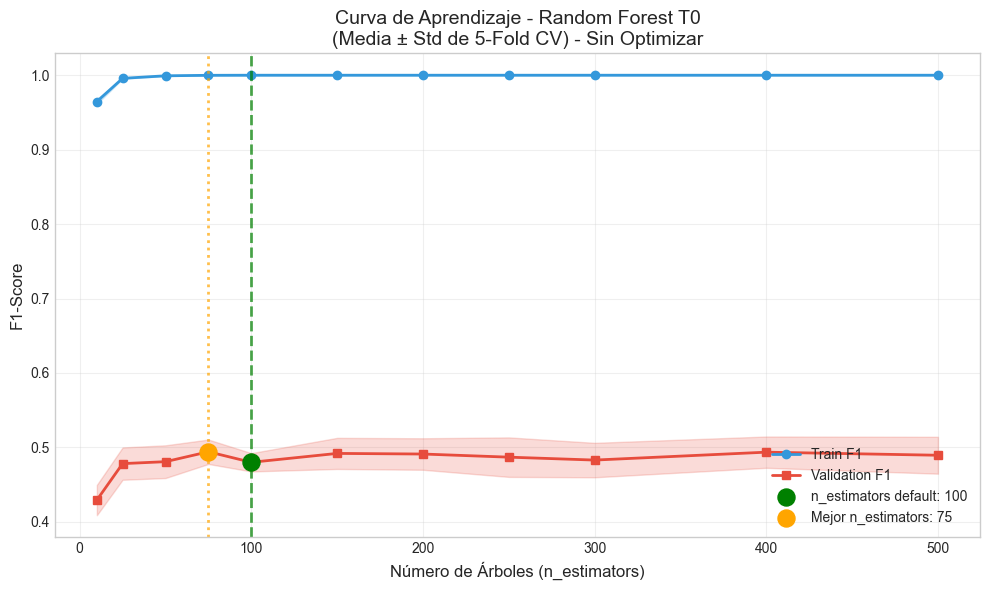


Resumen Curva de Aprendizaje:
   n_estimators por defecto: 100
   Mejor n_estimators (curva): 75
   Train F1 en n=100: 1.0000
   Val F1 en n=100: 0.4799
   Gap en n=100: 0.5201
   Val F1 en mejor n: 0.4941
   Gap en mejor n: 0.5058

 Resumen Cross-Validation:

   Métrica        Train Mean    Train Std     Val Mean      Val Std
   ------------------------------------------------------------
   accuracy           1.0000       0.0000       0.7268       0.0109
   precision          1.0000       0.0000       0.6194       0.0310
   recall             1.0000       0.0000       0.3923       0.0107
   f1                 1.0000       0.0000       0.4799       0.0123
   roc_auc            1.0000       0.0000       0.7380       0.0057
🏃 View run RandomForest_CV5_T0 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/d212227799e64493a92f55f64e4f9b74
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797
Resultados guardados en: ../outputs/models/baseline_RF/cv_sum

In [11]:
# Entrenar y evaluar T0
results_T0 = entrena_RF(X_train_T0, y_train, fase='T0')

df_resumen_rf = resumen_cv(
    cv_results=results_T0['cv_results'],
    fase='T0',
    modelo='RandomForest'
)
# Guardar tabla de comparación
df_resumen_rf.to_csv(f"{OUTPUT_DIR_REPORTES}cv_summary_RF.csv", index=False)

print(f"Resultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_RF.csv")

### Optimización

  OPTIMIZACIÓN RANDOM FOREST CON OPTUNA - FASE T0

Variables: 18
Registros en train: 3539
Trials Optuna: 25
Métrica a optimizar: F1-score (clase Dropout)

Proceso de optimización

  MEJORES HIPERPARÁMETROS
  Mejor F1-score (CV): 0.5811
    n_estimators: 148
    max_depth: 17
    min_samples_split: 2
    min_samples_leaf: 10
    max_features: log2
    class_weight: balanced_subsample

Genera curva de aprendizaje


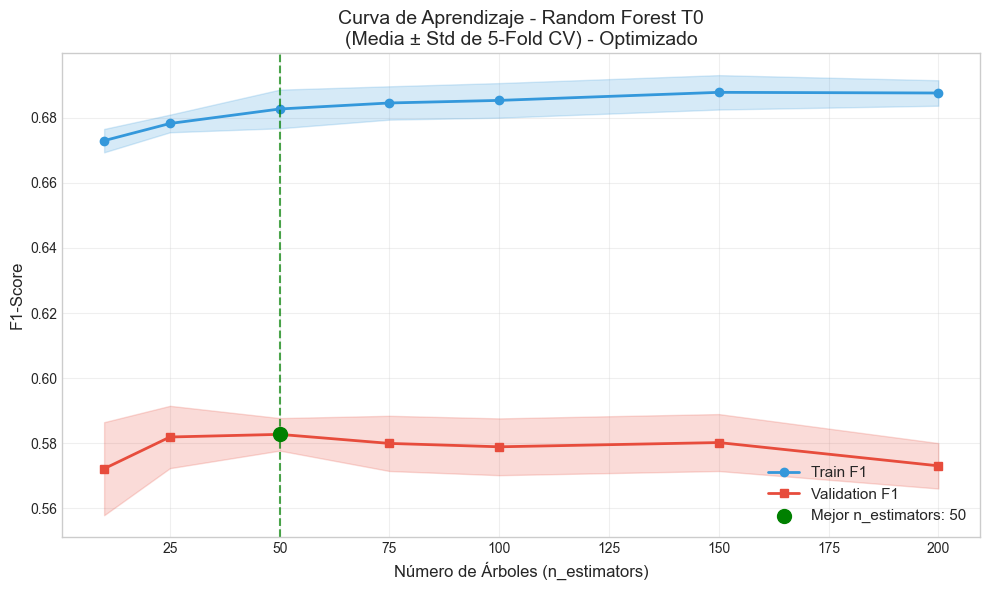


Resumen Curva de Aprendizaje:
   Mejor n_estimators: 50
   Train F1 final: 0.6876
   Val F1 final: 0.5731
   Val F1 máximo: 0.5827
   Gap (Train - Val): 0.1145

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.7770     0.0032       0.6979     0.0073
   precision          0.6247     0.0044       0.5245     0.0105
   recall             0.7663     0.0106       0.6526     0.0273
   f1                 0.6882     0.0054       0.5811     0.0087****
   roc_auc            0.8621     0.0017       0.7554     0.0031
🏃 View run Optuna_RandomForest_CV5_T0 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/a1f73bc94fa04a1e8755648c3524d8c1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Comparación F1-score:
  Baseline: 0.4799
  Optuna:   0.5811

Resultados guardados en: ../outputs/models/baseline_RF/cv_summary_RF.cs

In [12]:
results_T0_optuna = entrena_RF_con_optuna(X_train_T0, y_train, fase='T0', n_trials=25)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T0['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T0_optuna['best_f1_score_cv']:.4f}")

df_resumen_rf_T0_opt = resumen_cv(
    cv_results=results_T0_optuna['cv_results'],
    fase='T0',
    modelo='RandomForest_opt'
)

rf_path = "../outputs/models/baseline_RF/cv_summary_RF.csv"
df_rf = pd.read_csv(rf_path)
df_final = pd.concat([df_rf, df_resumen_rf_T0_opt], ignore_index=True)
csv_path = "cv_summary_RF.csv"

# Guardar tabla de comparación
df_final.to_csv(rf_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_RF.csv")

### Comentarios FASE 0

1. Se observa que todas las métricas en entrenamiento alcanzan valor máximo (1.0) lo que indica sobreentrenamiento severo. El recall es 0.3984 lo cual indica una baja capacidad de predicción.
2. Las métricas de validación caen de forma relevente, en consecuencia, no generaliza adecuadamente.
2. Estos resultados son inferioes a la RL, en consecuencia no es adecuado para predecir de forma temprana en esta fase.

## 7. Modelado FASE T1 (FIN 1ER SEMESTRE)

In [13]:
# Preprocesamiento para T1
X_train_T1, X_test_T1, features_T1, prep_T1 = preprocesamiento_RF(
    X_train, X_test, y_train, fase='T1'
)

print(f"\nT1 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T1.shape}")
print(f"   Test:  {X_test_T1.shape}")
print(f"   Features: {len(features_T1)}")
print(f"   \nLas variables son:")
X_train_T1.columns


T1 - Dimensiones después del preprocesamiento:
   Train: (3539, 29)
   Test:  (885, 29)
   Features: 29
   
Las variables son:


Index(['daytimeevening_attendance', 'displaced', 'educational_special_needs',
       'gender', 'scholarship_holder', 'international', 'is_single',
       'age_at_enrollment', 'admission_grade', 'previous_qualification_grade',
       'application_mode_risk', 'previous_qualification_risk',
       'mothers_qualification_level', 'fathers_qualification_level',
       'mothers_occupation_level', 'fathers_occupation_level',
       'application_order', 'debtor', 'tuition_fees_up_to_date',
       'curricular_units_1st_sem_credited',
       'curricular_units_1st_sem_enrolled',
       'curricular_units_1st_sem_evaluations',
       'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade',
       'curricular_units_1st_sem_without_evaluations', 'unemployment_rate',
       'inflation_rate', 'gdp', 'course_encoded'],
      dtype='object')

### Parámetros por defecto

  ENTRENAMIENTO Random Forest - FASE T1

Variables: 29
Registros: 3539

Hiperparámetros (por defecto):
   • n_estimators: 100
   • max_depth: None (sin límite)
   • min_samples_split: 2
   • min_samples_leaf: 1
   • max_features: sqrt
   • class_weight: balanced

Cross-Validation (5-fold):

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 1.0000 | Val: 0.8588
    precision  | Train: 1.0000 | Val: 0.8404
    recall     | Train: 1.0000 | Val: 0.6930
    f1         | Train: 1.0000 | Val: 0.7596
    roc_auc    | Train: 1.0000 | Val: 0.8943

  Fold 2:
    accuracy   | Train: 1.0000 | Val: 0.8517
    precision  | Train: 1.0000 | Val: 0.8475
    recall     | Train: 1.0000 | Val: 0.6579
    f1         | Train: 1.0000 | Val: 0.7407
    roc_auc    | Train: 1.0000 | Val: 0.8797

  Fold 3:
    accuracy   | Train: 1.0000 | Val: 0.8418
    precision  | Train: 1.0000 | Val: 0.8010
    recall     | Train: 1.0000 | Val: 0.6740
    f1         | Train: 1.0000 | Val: 0.7321
    roc_auc    | Train:

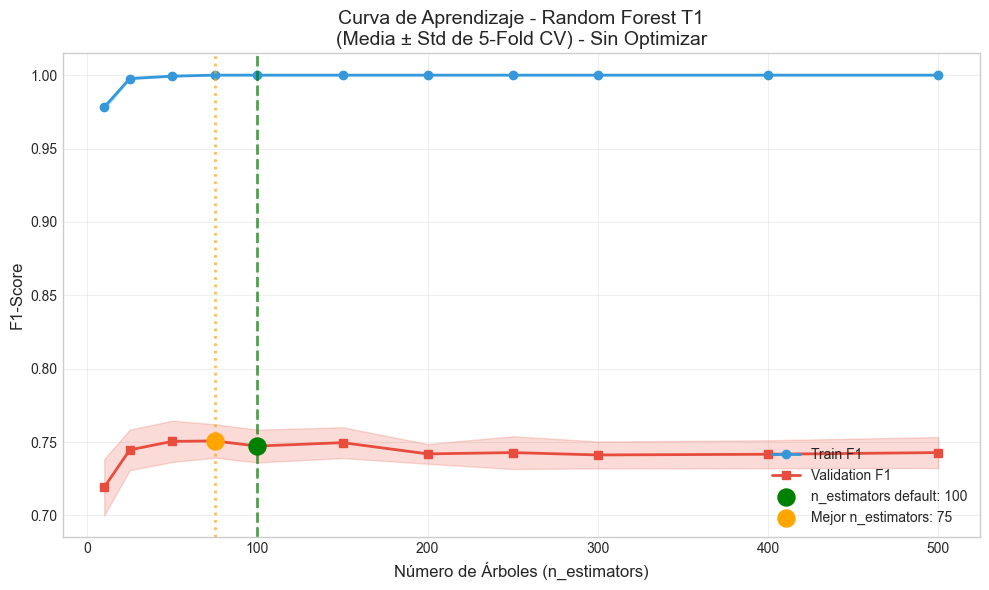


Resumen Curva de Aprendizaje:
   n_estimators por defecto: 100
   Mejor n_estimators (curva): 75
   Train F1 en n=100: 1.0000
   Val F1 en n=100: 0.7473
   Gap en n=100: 0.2527
   Val F1 en mejor n: 0.7508
   Gap en mejor n: 0.2492

 Resumen Cross-Validation:

   Métrica        Train Mean    Train Std     Val Mean      Val Std
   ------------------------------------------------------------
   accuracy           1.0000       0.0000       0.8539       0.0080
   precision          1.0000       0.0000       0.8425       0.0279
   recall             1.0000       0.0000       0.6719       0.0118
   f1                 1.0000       0.0000       0.7473       0.0112
   roc_auc            1.0000       0.0000       0.8964       0.0095
🏃 View run RandomForest_CV5_T1 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/25b7252bd7954afe9dde6cbd10866040
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Resultados guardados en: ../outputs/models/baseline_RF/cv_su

In [14]:
# Entrenar y evaluar T1
results_T1 = entrena_RF(X_train_T1, y_train, fase='T1')

df_resumen_rf_T1 = resumen_cv(
    cv_results=results_T1['cv_results'],
    fase='T1',
    modelo='RandomForest'
)

rf_path = "../outputs/models/baseline_RF/cv_summary_RF.csv"
df_rf = pd.read_csv(rf_path)
df_final = pd.concat([df_rf, df_resumen_rf_T1], ignore_index=True)

# Guardar tabla de comparación
df_final.to_csv(rf_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_RF.csv")

### Optimización

  OPTIMIZACIÓN RANDOM FOREST CON OPTUNA - FASE T1

Variables: 29
Registros en train: 3539
Trials Optuna: 25
Métrica a optimizar: F1-score (clase Dropout)

Proceso de optimización

  MEJORES HIPERPARÁMETROS
  Mejor F1-score (CV): 0.7582
    n_estimators: 409
    max_depth: 13
    min_samples_split: 9
    min_samples_leaf: 4
    max_features: sqrt
    class_weight: balanced_subsample

Genera curva de aprendizaje


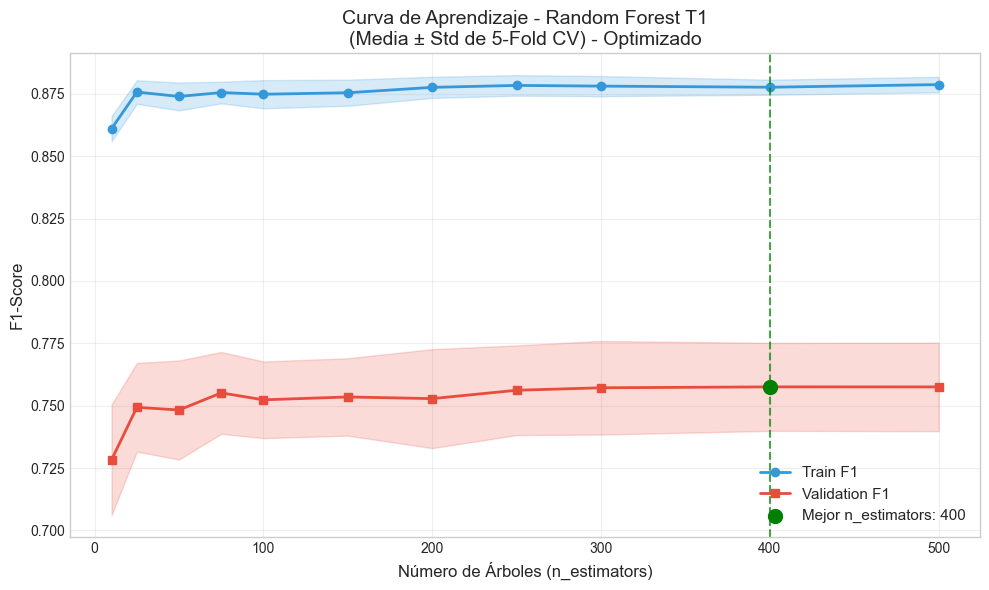


Resumen Curva de Aprendizaje:
   Mejor n_estimators: 400
   Train F1 final: 0.8787
   Val F1 final: 0.7575
   Val F1 máximo: 0.7575
   Gap (Train - Val): 0.1212

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.9221     0.0021       0.8491     0.0100
   precision          0.8814     0.0049       0.7814     0.0194
   recall             0.8753     0.0075       0.7371     0.0266
   f1                 0.8783     0.0035       0.7582     0.0175****
   roc_auc            0.9787     0.0004       0.8947     0.0092
🏃 View run Optuna_RandomForest_CV5_T1 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/8572bc38f53a4a80ae2cd03356db7d2a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Comparación F1-score:
  Baseline: 0.7473
  Optuna:   0.7582


In [15]:
results_T1_optuna = entrena_RF_con_optuna(X_train_T1, y_train, fase='T1', n_trials=25)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T1['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T1_optuna['best_f1_score_cv']:.4f}")

df_resumen_rf_T1_opt = resumen_cv(
    cv_results=results_T1_optuna['cv_results'],
    fase='T1',
    modelo='RandomForest_opt'
)

rf_path = "../outputs/models/baseline_RF/cv_summary_RF.csv"
df_rf = pd.read_csv(rf_path)
df_final = pd.concat([df_rf, df_resumen_rf_T1_opt], ignore_index=True)
csv_path = "cv_summary_RF.csv"

# Guardar tabla de comparación
df_final.to_csv(rf_path, index=False)

### Comentarios FASE 1

1. Se mantiene las métricas perfectas de la fase 0, se mantiene en sobreentrenamiento.
2. Se observa una mejora con la incorporación de la Fase 0, con un recall de 0.6211 y AUC 0.9006 sin embargo, la caída de las métricas en validación es de importancia (prromerio 0.2), no generaliza de forma adecuada.
3. Aunque en rendimiento mejora, es inferior a la RL.

## 8. Modelado FASE T2 (FIN 2DO SEMESTRE)

In [16]:
# Preprocesamiento para T2
X_train_T2, X_test_T2, features_T2, prep_T2 = preprocesamiento_RF(
    X_train, X_test, y_train, fase='T2'
)

print(f"\nT2 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T2.shape}")
print(f"   Test:  {X_test_T2.shape}")
print(f"   Features: {len(features_T2)}")
print(f"   \nLas variables son:")
X_train_T2.columns


T2 - Dimensiones después del preprocesamiento:
   Train: (3539, 35)
   Test:  (885, 35)
   Features: 35
   
Las variables son:


Index(['daytimeevening_attendance', 'displaced', 'educational_special_needs',
       'gender', 'scholarship_holder', 'international', 'is_single',
       'age_at_enrollment', 'admission_grade', 'previous_qualification_grade',
       'application_mode_risk', 'previous_qualification_risk',
       'mothers_qualification_level', 'fathers_qualification_level',
       'mothers_occupation_level', 'fathers_occupation_level',
       'application_order', 'debtor', 'tuition_fees_up_to_date',
       'curricular_units_1st_sem_credited',
       'curricular_units_1st_sem_enrolled',
       'curricular_units_1st_sem_evaluations',
       'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade',
       'curricular_units_1st_sem_without_evaluations', 'unemployment_rate',
       'inflation_rate', 'gdp', 'curricular_units_2nd_sem_credited',
       'curricular_units_2nd_sem_enrolled',
       'curricular_units_2nd_sem_evaluations',
       'curricular_units_2nd_sem_approved', 'curricular_units_2nd

  ENTRENAMIENTO Random Forest - FASE T2

Variables: 35
Registros: 3539

Hiperparámetros (por defecto):
   • n_estimators: 100
   • max_depth: None (sin límite)
   • min_samples_split: 2
   • min_samples_leaf: 1
   • max_features: sqrt
   • class_weight: balanced

Cross-Validation (5-fold):

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 1.0000 | Val: 0.8771
    precision  | Train: 1.0000 | Val: 0.8691
    recall     | Train: 1.0000 | Val: 0.7281
    f1         | Train: 1.0000 | Val: 0.7924
    roc_auc    | Train: 1.0000 | Val: 0.9074

  Fold 2:
    accuracy   | Train: 1.0000 | Val: 0.8686
    precision  | Train: 1.0000 | Val: 0.8729
    recall     | Train: 1.0000 | Val: 0.6930
    f1         | Train: 1.0000 | Val: 0.7726
    roc_auc    | Train: 1.0000 | Val: 0.9101

  Fold 3:
    accuracy   | Train: 1.0000 | Val: 0.8616
    precision  | Train: 1.0000 | Val: 0.8525
    recall     | Train: 1.0000 | Val: 0.6872
    f1         | Train: 1.0000 | Val: 0.7610
    roc_auc    | Train:

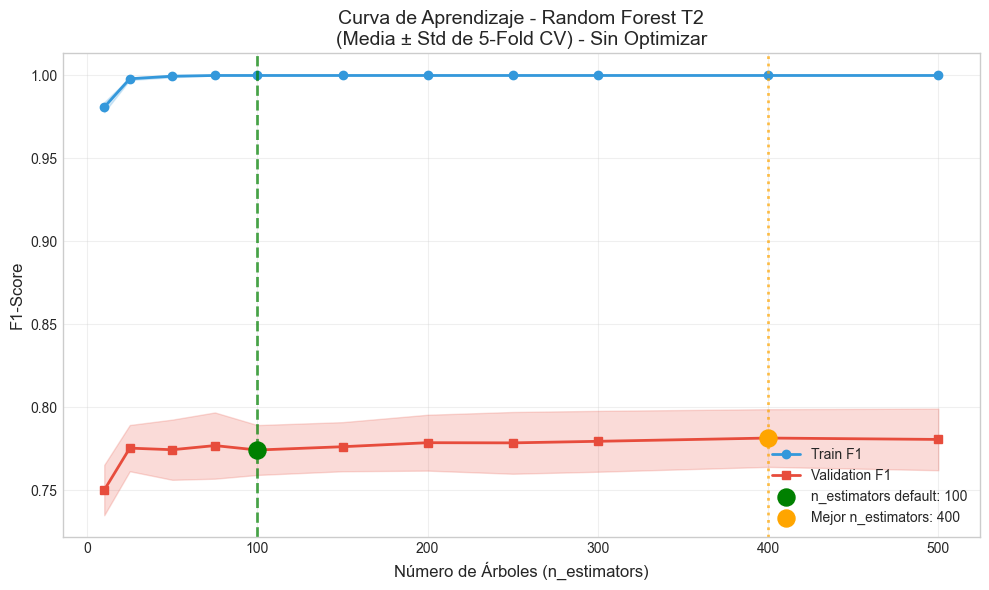


Resumen Curva de Aprendizaje:
   n_estimators por defecto: 100
   Mejor n_estimators (curva): 400
   Train F1 en n=100: 1.0000
   Val F1 en n=100: 0.7742
   Gap en n=100: 0.2258
   Val F1 en mejor n: 0.7814
   Gap en mejor n: 0.2186

 Resumen Cross-Validation:

   Métrica        Train Mean    Train Std     Val Mean      Val Std
   ------------------------------------------------------------
   accuracy           1.0000       0.0000       0.8695       0.0086
   precision          1.0000       0.0000       0.8717       0.0226
   recall             1.0000       0.0000       0.6965       0.0169
   f1                 1.0000       0.0000       0.7742       0.0150
   roc_auc            1.0000       0.0000       0.9143       0.0078
🏃 View run RandomForest_CV5_T2 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/ee7b565fbd594dcd82cd2ee88a5c08a4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Resultados guardados en: ../outputs/models/baseline_RF/cv_s

In [17]:
# Entrenar y evaluar T2
results_T2 = entrena_RF(X_train_T2, y_train, fase='T2')

df_resumen_rf_T2 = resumen_cv(
    cv_results=results_T2['cv_results'],
    fase='T2',
    modelo='RandomForest'
)

rf_path = "../outputs/models/baseline_RF/cv_summary_RF.csv"
df_rf = pd.read_csv(rf_path)
df_final = pd.concat([df_rf, df_resumen_rf_T2], ignore_index=True)
csv_path = "cv_summary_RF.csv"

# Guardar tabla de comparación
df_final.to_csv(rf_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_RF.csv")

### Optimización

  OPTIMIZACIÓN RANDOM FOREST CON OPTUNA - FASE T2

Variables: 35
Registros en train: 3539
Trials Optuna: 25
Métrica a optimizar: F1-score (clase Dropout)

Proceso de optimización

  MEJORES HIPERPARÁMETROS
  Mejor F1-score (CV): 0.7885
    n_estimators: 135
    max_depth: 10
    min_samples_split: 2
    min_samples_leaf: 4
    max_features: sqrt
    class_weight: balanced

Genera curva de aprendizaje


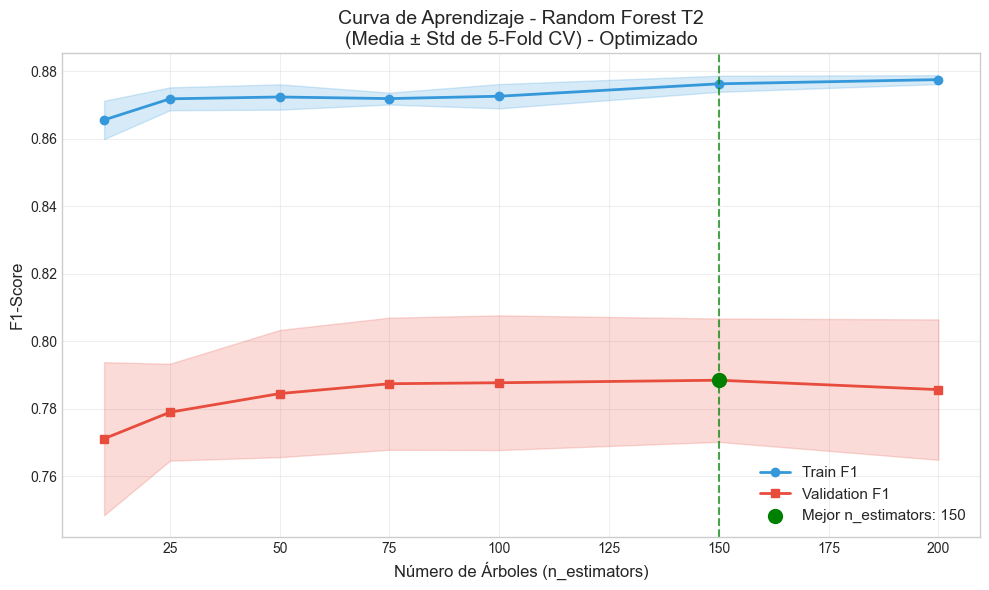


Resumen Curva de Aprendizaje:
   Mejor n_estimators: 150
   Train F1 final: 0.8775
   Val F1 final: 0.7857
   Val F1 máximo: 0.7885
   Gap (Train - Val): 0.0918

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.9204     0.0019       0.8661     0.0119
   precision          0.8847     0.0049       0.8011     0.0254
   recall             0.8650     0.0029       0.7766     0.0165
   f1                 0.8747     0.0029       0.7885     0.0174****
   roc_auc            0.9722     0.0005       0.9141     0.0092
🏃 View run Optuna_RandomForest_CV5_T2 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/ea46d66741634801876b8e451e94e2fc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Comparación F1-score:
  Baseline: 0.7742
  Optuna:   0.7885


In [18]:
results_T2_optuna = entrena_RF_con_optuna(X_train_T2, y_train, fase='T2', n_trials=25)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T2['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T2_optuna['best_f1_score_cv']:.4f}")


df_resumen_rf_T2_opt = resumen_cv(
    cv_results=results_T2_optuna['cv_results'],
    fase='T2',
    modelo='RandomForest_opt'
)

rf_path = "../outputs/models/baseline_RF/cv_summary_RF.csv"
df_rf = pd.read_csv(rf_path)
df_final = pd.concat([df_rf, df_resumen_rf_T2_opt], ignore_index=True)
csv_path = "cv_summary_RF.csv"

# Guardar tabla de comparación
df_final.to_csv(rf_path, index=False)

### Comentarios FASE 2

1. Se mantiene las métricas perfectas de la fase 0, el sobreentrenamiento se conirma de forma persistente en todas las fases.
2. En validación, se observa una mejora con la incorporación de la Fase 1, con un recall de 0.7027 y AUC 0.9150 sin embargo, la caída de las métricas en validación es de importancia (promedio 0.1748), continua con una generalización no adecuada.

## 9. Resumen Final Random Forest

In [19]:
# Mostrar resumen final
df_final = pd.read_csv(f"{OUTPUT_DIR_REPORTES}cv_summary_RF.csv")

print("================================================================================")
print("  RESUMEN Random Forest - CROSS VALIDATION")
print("================================================================================")
print(df_final.to_string(index=False))

  RESUMEN Random Forest - CROSS VALIDATION
          modelo fase  accuracy_val_mean  accuracy_val_std  precision_val_mean  precision_val_std  recall_val_mean  recall_val_std  f1_val_mean  f1_val_std  roc_auc_val_mean  roc_auc_val_std  accuracy_train_mean  accuracy_train_std  precision_train_mean  precision_train_std  recall_train_mean  recall_train_std  f1_train_mean  f1_train_std  roc_auc_train_mean  roc_auc_train_std
    RandomForest   T0             0.7268            0.0109              0.6194             0.0310           0.3923          0.0107       0.4799      0.0123            0.7380           0.0057               1.0000              0.0000                1.0000               0.0000             1.0000            0.0000         1.0000        0.0000              1.0000             0.0000
RandomForest_opt   T0             0.6979            0.0073              0.5245             0.0105           0.6526          0.0273       0.5811      0.0087            0.7554           0.0031       

## 10. Resumen completo de entrenamiento (Todos los algoritmos)

In [20]:
import pandas as pd
rl_path = "../outputs/models/baseline_RL/cv_summary_RL.csv"
df_rl = pd.read_csv(rl_path)

rf_path = "../outputs/models/baseline_RF/cv_summary_RF.csv"
df_rf = pd.read_csv(rf_path)

df_resumen = pd.concat([df_rl, df_rf], ignore_index=True)

# Guardar tabla de comparación
df_resumen.to_csv(f"../outputs/models/cv_summary_entrenamiento.csv", index=False)

print(f"Resultados guardados en: ../outputs/models/cv_summary_entrenamiento.csv")

Resultados guardados en: ../outputs/models/cv_summary_entrenamiento.csv


## Conclusión

Aunque Random Forest presenta una mejora progresiva del rendimiento con la incorporación de variables, presenta un sobreajuste severo con alta varianza en todas las las fases en el conjunto de entrenamiento y una diferrencia relevante en las métricas con datos de validación. Este comportamiento, junto con un recall inferior al los resultados de la RL, limita su idoneidad para la detección temprana de la deserción estudiantil.